## Imports

In [1]:
import glob
import os
import pickle
import pprint
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Subset

import dgl
from dgl.nn import GraphConv
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset

import networkx as nx

from utils.dataset_maker import connected_subset, ContrastiveDataset, GraphAugmentation, train_test_val_split
from utils.gnn import GCNEncoder, train

from IPython.display import clear_output

Using backend: pytorch


In [2]:
DATA_DIR = "data"
INTERIM_DIR = "interim"
MODEL = "models"

In [3]:
pp = pprint.PrettyPrinter(indent=4)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

Device:  cpu


## Load data

We collect the dataset for this experiment from the prepared datasets. The samll graphs look very much like snowflakes. For each account, which label we can define in advance, we try to enrich the data by collecting the information about its neighbors.

In [5]:
gs = []
train_test = []
labels_ = []
dataset_1hop_fp = os.path.join("..", DATA_DIR, INTERIM_DIR, "dataset_for_semisupervised_1hop")
dataset_fp = os.path.join("..", DATA_DIR, INTERIM_DIR, "nodes_0", "*.csv")

for file in glob.glob(dataset_fp):
    df = pd.read_csv(file, index_col="Unnamed: 0").drop_duplicates().astype(int)
    train_test.append(df.drop("n_groups", axis=1).iloc[0])
    centers = np.repeat(0, len(df))
    endpoints = np.arange(len(df))
    data = np.array(df.drop("n_groups", axis=1))

    g = dgl.graph((torch.tensor(centers.tolist()), torch.tensor(endpoints.tolist())))
    g = dgl.to_bidirected(g)
    g.ndata["attr"] = torch.tensor(data)
    gs.append(g)
    l = file[-5]
    labels_.append(int(l))
    
labels = {"labels": torch.tensor(labels_)}

## Data augmentation

We extent the datasets with augmentations. For this experiments we use graph augmentations from <a href="https://arxiv.org/abs/2103.00111">the article</a>. The augmentations from the articles are packed as a GraphAugmentation class in the dataset_maker file from utils. Here we used "mask" augmentation and perturbation augmentation, both of which in our assumption shouldn't have changed the natire of the graph.

In [6]:
augmentations_pert = []
augmentations_mask = []
augmentations_drop = []
augmentations_pert.append(GraphAugmentation("pert_edges", ratio=0.1))
augmentations_mask.append(GraphAugmentation("attr_mask", ratio=0.3, node_feat='attr'))
augmentations_drop.append(GraphAugmentation("drop_nodes", ratio=0.1))
augmentations_pert.append(GraphAugmentation("identical"))
augmentations_mask.append(GraphAugmentation("identical"))
augmentations_drop.append(GraphAugmentation("identical"))

dataset_pert = ContrastiveDataset(
    filename=dataset_1hop_fp,
    augmentations=augmentations_pert
)
dataset_mask = ContrastiveDataset(
    filename=dataset_1hop_fp,
    augmentations=augmentations_mask
)
dataset_drop = ContrastiveDataset(
    filename=dataset_1hop_fp,
    augmentations=augmentations_drop
)
n = len(dataset_drop)
n

285

In [7]:
c_dataset_pert = connected_subset(dataset_pert)
c_dataset_mask = connected_subset(dataset_mask)
c_dataset_drop = connected_subset(dataset_drop)

## Visulaize and split data

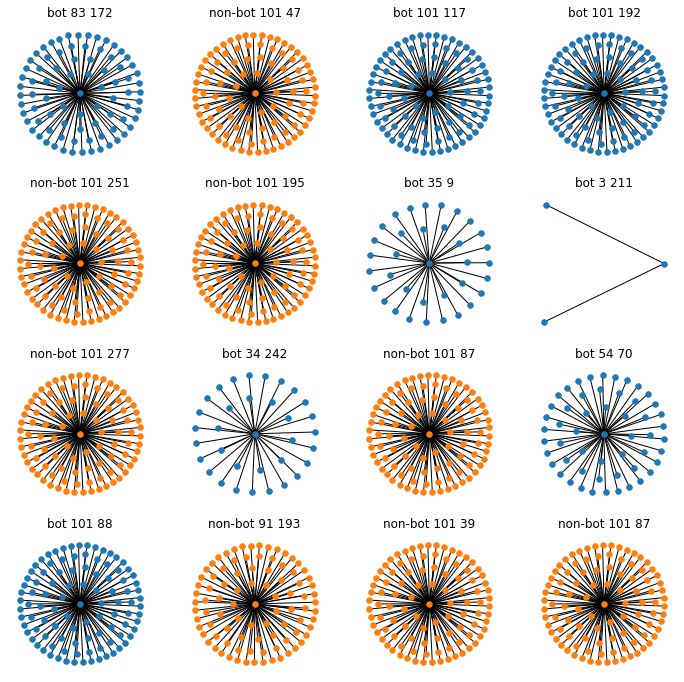

In [8]:
colors = ['tab:orange', 'tab:blue']
plt.figure(figsize=(12, 12))
np.random.seed(0)
for i in range(16):
    plt.subplot(4, 4, i+1)
    n_rand = np.random.randint(n)
    g, _, _, l = c_dataset_mask[n_rand]
    g = nx.Graph(g.to_networkx())
    g.remove_edges_from(nx.selfloop_edges(g))
    n_nodes = g.number_of_nodes()
    nx.draw_kamada_kawai(g, node_size=30, node_color=colors[l])
    plt.title(f'bot {n_nodes} {n_rand}' if l == 1 else f'non-bot {n_nodes} {n_rand}')

In [9]:
np.random.seed(0)
ratio = [0.6, 0.2, 0.2]
split_idx = ["train"] * int(ratio[0] * n) \
    + ["test"] * int(ratio[1] * n) \
    + ["val"] * int(ratio[2] * n)
split_idx = np.random.permutation(split_idx)
train_idx = np.where(split_idx == "train")[0]
test_idx = np.where(split_idx == "test")[0]
val_idx = np.where(split_idx == "val")[0]

graph_train_p, graph_test_p, graph_val_p, y_train_p, y_test_p, y_val_p = train_test_val_split(
    c_dataset_pert, train_idx, test_idx, val_idx
)
graph_train_m, graph_test_m, graph_val_m, y_train_m, y_test_m, y_val_m = train_test_val_split(
    c_dataset_mask, train_idx, test_idx, val_idx
)
graph_train_d, graph_test_d, graph_val_d, y_train_d, y_test_d, y_val_d = train_test_val_split(
    c_dataset_drop, train_idx, test_idx, val_idx
)

## GNN Encoder for dataset with perturbation

Now we are ready for experiments. We train a neural network to represent our graphs as an embedding, then we forward those embeddings to a classifier (Random Forest in this particular case).

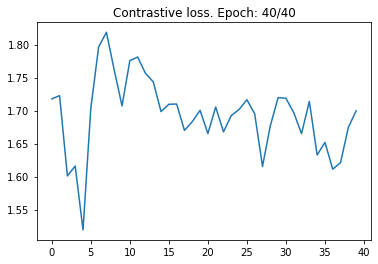

In [10]:
encoder_pert = GCNEncoder(input_dim=4, hidden_dim=8, emb_dim=16, output_dim=32)
encoder_pert.to(device)

loader_pert = GraphDataLoader(
    c_dataset_pert,
    batch_size=32,
    drop_last=False,
    shuffle=True)
opt = Adam(encoder_pert.parameters(), lr=0.0005)
loss_vals = []
n_epochs = 40

for i in range(n_epochs):
    loss_epoch = []
    for batch, aug_batch1, aug_batch2, label in loader_pert:
        loss_item = train(encoder_pert, aug_batch1, aug_batch2, opt)
        loss_epoch.append(loss_item)
    loss_vals.append(sum(loss_epoch)/len(loss_epoch))
    plt.plot(loss_vals)
    plt.title('Contrastive loss. Epoch: {}/{}'.format(i+1, n_epochs))
    plt.show();
    clear_output(wait=True)

In [11]:
with torch.no_grad():
    X_test_p = encoder_pert(graph_test_p, "attr").to(device)
    X_val_p = encoder_pert(graph_val_p, "attr").to(device)

We then check the performance of our classifier.

In [12]:
clf_p = RandomForestClassifier()
clf_p.fit(X_test_p, y_test_p)
y_pred = clf_p.predict(X_val_p)
print("True values:")
pp.pprint(y_val_p)
print("Prediction:")
pp.pprint(y_pred)
prec = precision_score(y_pred, y_val_p)
recall = recall_score(y_pred, y_val_p)
f1 = f1_score(y_pred, y_val_p)
acc = accuracy_score(y_pred, y_val_p)
rocauc = roc_auc_score(y_pred, y_val_p)
print("Precision: ", prec)
print("Recall   : ", recall)
print("F1       : ", f1)
print("Accuracy : ", acc)
print("ROCAUC   : ", rocauc)

True values:
tensor([1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1.])
Prediction:
array([1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 0., 0., 1.], dtype=float32)
Precision:  0.8461538461538461
Recall   :  0.9428571428571428
F1       :  0.8918918918918919
Accuracy :  0.8596491228070176
ROCAUC   :  0.8350649350649351


And repeat the process for all augmented datasets.

## GNN Encoder for dataset with mask

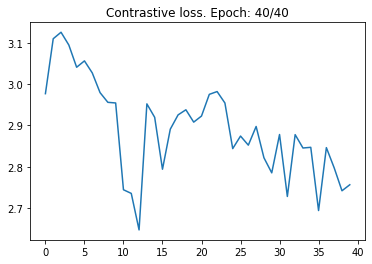

In [13]:
encoder_mask = GCNEncoder(input_dim=4, hidden_dim=8, emb_dim=16, output_dim=32)
encoder_mask.to(device)

loader_mask = GraphDataLoader(
    c_dataset_mask,
    batch_size=32,
    drop_last=False,
    shuffle=True)
opt = Adam(encoder_mask.parameters(), lr=0.0005)
loss_vals = []
n_epochs = 40

for i in range(n_epochs):
    loss_epoch = []
    for batch, aug_batch1, aug_batch2, label in loader_mask:
        loss_item = train(encoder_mask, aug_batch1, aug_batch2, opt)
        loss_epoch.append(loss_item)
    loss_vals.append(sum(loss_epoch)/len(loss_epoch))
    plt.plot(loss_vals)
    plt.title('Contrastive loss. Epoch: {}/{}'.format(i+1, n_epochs))
    plt.show();
    clear_output(wait=True)

In [14]:
with torch.no_grad():
    X_test_m = encoder_mask(graph_test_m, "attr").to(device)
    X_val_m = encoder_mask(graph_val_m, "attr").to(device)

In [15]:
clf_m = RandomForestClassifier()
clf_m.fit(X_test_m, y_test_m)
y_pred = clf_m.predict(X_val_m)
print("True values:")
pp.pprint(y_val_m)
print("Prediction:")
pp.pprint(y_pred)
prec = precision_score(y_pred, y_val_m)
recall = recall_score(y_pred, y_val_m)
f1 = f1_score(y_pred, y_val_m)
acc = accuracy_score(y_pred, y_val_m)
rocauc = roc_auc_score(y_pred, y_val_m)
print("Precision: ", prec)
print("Recall   : ", recall)
print("F1       : ", f1)
print("Accuracy : ", acc)
print("ROCAUC   : ", rocauc)

True values:
tensor([1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1.])
Prediction:
array([1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1.], dtype=float32)
Precision:  0.6923076923076923
Recall   :  0.9642857142857143
F1       :  0.8059701492537313
Accuracy :  0.7719298245614035
ROCAUC   :  0.7752463054187193


## GNN Encoder for dataset with drop

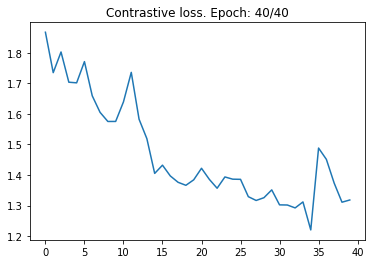

In [16]:
encoder_drop = GCNEncoder(input_dim=4, hidden_dim=8, emb_dim=16, output_dim=32)
encoder_drop.to(device)

loader_drop = GraphDataLoader(
    c_dataset_drop,
    batch_size=32,
    drop_last=False,
    shuffle=True)
opt = Adam(encoder_drop.parameters(), lr=0.0005)
loss_vals = []
n_epochs = 40

for i in range(n_epochs):
    loss_epoch = []
    for batch, aug_batch1, aug_batch2, label in loader_pert:
        loss_item = train(encoder_drop, aug_batch1, aug_batch2, opt)
        loss_epoch.append(loss_item)
    loss_vals.append(sum(loss_epoch)/len(loss_epoch))
    plt.plot(loss_vals)
    plt.title('Contrastive loss. Epoch: {}/{}'.format(i+1, n_epochs))
    plt.show();
    clear_output(wait=True)

In [17]:
with torch.no_grad():
    X_test_d = encoder_drop(graph_test_d, "attr").to(device)
    X_val_d = encoder_drop(graph_val_d, "attr").to(device)

In [18]:
clf_d = RandomForestClassifier()
clf_d.fit(X_test_d, y_test_d)
y_pred = clf_d.predict(X_val_d)
print("True values:")
pp.pprint(y_val_d)
print("Prediction:")
pp.pprint(y_pred)
prec = precision_score(y_pred, y_val_d)
recall = recall_score(y_pred, y_val_d)
f1 = f1_score(y_pred, y_val_d)
acc = accuracy_score(y_pred, y_val_d)
rocauc = roc_auc_score(y_pred, y_val_d)
print("Precision: ", prec)
print("Recall   : ", recall)
print("F1       : ", f1)
print("Accuracy : ", acc)
print("ROCAUC   : ", rocauc)

True values:
tensor([1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1.])
Prediction:
array([1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 1.], dtype=float32)
Precision:  0.7948717948717948
Recall   :  0.96875
F1       :  0.8732394366197183
Accuracy :  0.8421052631578947
ROCAUC   :  0.824375


We can see, that from all the metrics Recall is the one that seems to be slightly better than the one of the classic approaches.